In [1]:
import pickle
import numpy as np

####################################################################################################
# The datafiles are here: mint.uvt.nl:/roaming/gchrupal/vgs/experiments/flickr8k-segmatch_s3_grl-3/
####################################################################################################

# Load validation sentence data
sent = pickle.load(open("val_sentences.pkl", "rb"))
# Load validation embeddings
emb  = np.load("val_embeddings.npy")

You need to install vg in order to run the cell below.

```
git clone git@github.com:gchrupala/vgs.git
cd vgs
python3 setup.py develop --user
```

In [2]:
# Compute scores for paraphrase retrieval
from vg.evaluate import paraphrase_ranking
N = len(sent)
correct = np.zeros((N, N)).astype(bool)

In [3]:
for i in range(N):
    for j in range(N):
        if sent[i]['imgid'] == sent[j]['imgid'] and i != j:
                correct[i, j] = True

In [4]:
result = paraphrase_ranking(emb, correct)
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))

Median rank: 20.0
Recall @ 10: 0.1263


In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit_transform(emb)
print(pca.explained_variance_)

[ 0.67795345  0.09924861]


In [6]:
# Results for just the 2D projected embeddings
result = paraphrase_ranking(X, correct)
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))

Median rank: 10.0
Recall @ 10: 0.2077


In [7]:
# Results for just the first PC
result = paraphrase_ranking(X[:,:1], correct)
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))

Median rank: 1185.0
Recall @ 10: 0.00285


In [8]:
# Results for just the second PC
result = paraphrase_ranking(X[:,1:], correct)
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))

Median rank: 2152.5
Recall @ 10: 0.00115


In [9]:
# Hmm maybe we need euclidean with just a single dim
print("PC1")
result = paraphrase_ranking(X[:,0:], correct, metric='euclidean')
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))
print("PC2")
result = paraphrase_ranking(X[:,1:], correct, metric='euclidean')
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))

PC1
Median rank: 10.0
Recall @ 10: 0.21705
PC2
Median rank: 25.0
Recall @ 10: 0.09165


In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


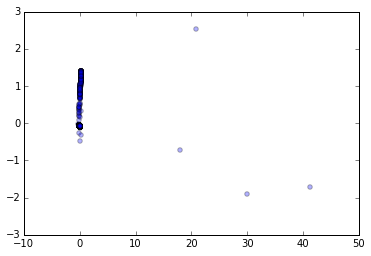

In [11]:
# What does the PCA space look like

scatter(X[:, 0], X[:,1], alpha=0.3)

In [21]:
# The retrieval scores are pretty decent
# Let's see some nearest neighbors
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity(X)
for i in range(0, 1000, 200):
    count = Counter()
    print(sent[i]['raw'])
    for k in range(1, 15):
        j = sim[i].argsort()[-k]
        if i != j:
            print(correct[i][j], sent[j]['imgid'], sent[j]['speaker'], sim[i,j], sent[j]['raw'])
            count.update([sent[j]['imgid']])
    print(count)
    print()
    

the boy laying face down on a skateboard is being pushed along the ground by another boy .
False 6193 flickr8k_72 0.999750289777 A white dog with beige spots is running through a field .
False 6678 flickr8k_181 0.999716008736 A large blue building has black smoke billowing out and a fire engine sits in front .
False 6862 flickr8k_22 0.983007153687 With the sun reflecting off the water , a man is sitting in a boat and rowing .
False 6813 flickr8k_17 0.787329813233 The dog is rolling on its back on the grass with its mouth wide open .
False 6042 flickr8k_57 0.645235010928 A young boy and a young girl walking towards each other
False 6043 flickr8k_109 0.644554972974 A black dog with a red collar is jumping out of the water .
False 6044 flickr8k_96 0.644154229255 Two people jump up and down on a cliff overlooking a valley .
False 6042 flickr8k_70 0.643926331109 A little girl and boy play Frisbee together in a grassy area .
False 6042 flickr8k_7 0.643843830704 A little boy and a little girl

In [13]:
# How correlated are these components with utterance length?
import scipy.stats
L = np.array([s['audio'].shape[0] for s in sent])
print(scipy.stats.pearsonr(X[:,0], L))
print(scipy.stats.pearsonr(X[:,1], L))

(0.062939351702091653, 8.4368629742701995e-06)
(0.53029651989930615, 0.0)


In [14]:
# Results for utterance length
result = paraphrase_ranking(L.reshape((len(L), 1)), correct, metric='euclidean')
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))

Median rank: 752.0
Recall @ 10: 0.0018


In [56]:
# We will pick N random utterances, and compute counts of image ids among 10 nearest neighbors.
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances

def purity(sim, size=100, seed=123, neighborhood=10):
    random.seed(123)
    maxes = []
    maxes_r = []
    for i in random.sample(range(len(sim)), size):
        count = Counter()
        for k in range(1, neighborhood):
            j = sim[i].argsort()[k]
            count.update([sent[j]['imgid']])
        maxes.append(max(count.values()))
        count = Counter()
        for k in random.sample(range(len(sim)), neighborhood):
            j = k
            count.update([sent[j]['imgid']])
        maxes_r.append(max(count.values()))
    return numpy.array(maxes), numpy.array(maxes_r)

In [63]:
M = 10
close, rand = purity(cosine_distances(X), size=1000, neighborhood=M)
print("Average number of paraphrases among {} neighbors: {}".format(M, numpy.mean(close)))
print("Average number of paraphrases among {} random sentences: {}".format(M, numpy.mean(rand)))

Average number of paraphrases among 10 neighbors: 2.339
Average number of paraphrases among 10 random sentences: 1.044


In [64]:
M = 10
close, rand = purity(cosine_distances(emb), size=1000, neighborhood=M)
print("Average number of paraphrases among {} neighbors: {}".format(M, numpy.mean(close)))
print("Average number of paraphrases among {} random sentences: {}".format(M, numpy.mean(rand)))

Average number of paraphrases among 10 neighbors: 2.605
Average number of paraphrases among 10 random sentences: 1.044
